In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator

5.7.3


In [2]:
#Enter the file path
path = './lows28FPGA_Real_Real_run2_part_threshold6701.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [3]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)

In [4]:
def Sort(sub_li): 
    l = len(sub_li) 
    for i in range(0, l): 
        for j in range(0, l-i-1): 
            if (sub_li[j][1] > sub_li[j + 1][1]): 
                tempo = sub_li[j] 
                sub_li[j]= sub_li[j + 1] 
                sub_li[j + 1]= tempo 
    return sub_li 

In [5]:
def SwapModule(slinks,SlinkAve,L1,L2):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    for i in ss:
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i
        slinkLow=ss[lowC]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=100000000
        flag=0
        for l in slinkHigh[1][1]:
            if abs((dif/2)-float(l[1])) < temp and dif > float(l[1]):
                lp=l[0]
                temp=abs((dif/2)-float(l[1]))
                flag=1
        #lp=Sort(slinkHigh[1][1])[0][0]
    
        if flag==1:
            for ilist,var in zip(L1,L2):
                if str(lp) in ilist:
                    var[str(lp),slinkHigh[0]].value=0
                    var[str(lp),slinkLow[0]].value=1
                else:
                    continue
            lowC-=1
            print("-------------OK--------------")
        print("-----------------------------")

In [6]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])
#print(Vars)
#print(Slink)

In [7]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


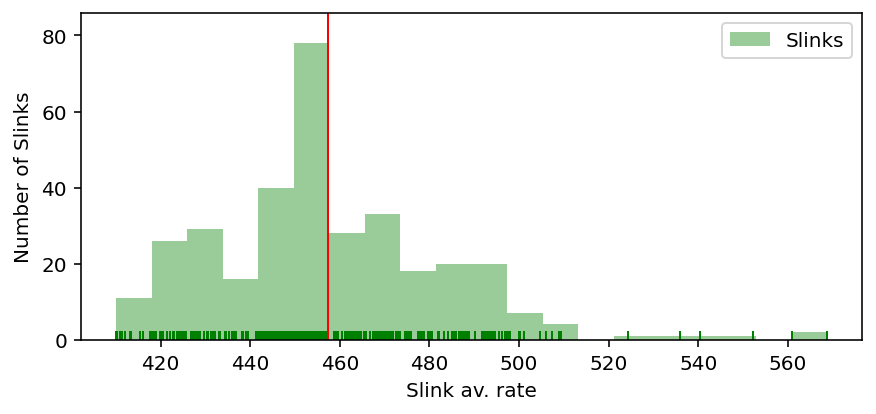

In [8]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
#slink_array=[]
#for i in Slink:
#    list=[]
#    for j in FPGA:
#        if 0.9<=pyo.value(model.GKSlinks[i,j])<=1.00001:
#            list.append(1)
#        else: #pyo.value(model.GKSlinks[i,j])==0:
#            list.append(0)
#    slink_array.append(list)
#Slinks=np.array(slink_array)
#Slinks_Rates=np.array(slink_rate_list)
#hml_slink=(Slinks.T*Slinks_Rates).T
#hml_slink
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

In [9]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 457.41893059523863
Std:  19.246068531537155
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 19.246068531537155


In [10]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value
                    GK[j][1].append([int(i),L3[int(i)]])
    return GK

SwapModule(swapData(),GKavSlinkRate,L1,L2)

('99', [568.6677199999999, [[335, 120.4824], [664, 155.27249999999998], [1169, 73.33174000000001], [1226, 65.0313], [1328, 85.6841], [1278, 68.86568]]])
('235', [410.1564, [[727, 103.2387], [412, 194.1922], [1154, 64.2868], [1142, 48.4387]]])
-------------OK--------------
-----------------------------
('130', [560.98284, [[501, 118.958], [1100, 158.2327], [460, 81.98100000000001], [1471, 27.9777], [1220, 55.118640000000006], [1060, 58.869099999999996], [1292, 59.84570000000001]]])
('176', [410.3806000000001, [[521, 110.57300000000001], [541, 172.6008], [680, 99.58010000000002], [1487, 27.6267]]])
-------------OK--------------
-----------------------------
('138', [552.20801, [[49, 119.8472], [1099, 157.83679999999998], [484, 101.39410000000001], [1260, 74.65511], [1022, 98.4748]]])
('311', [410.867, [[160, 410.867]]])
-------------OK--------------
-----------------------------
('161', [540.5049, [[396, 112.1518], [924, 167.5873], [1234, 78.6681], [641, 82.6902], [644, 99.4075]]])
('237

In [11]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 457.41893059523863
Std:  11.346127885572258
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 11.346127885572258


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


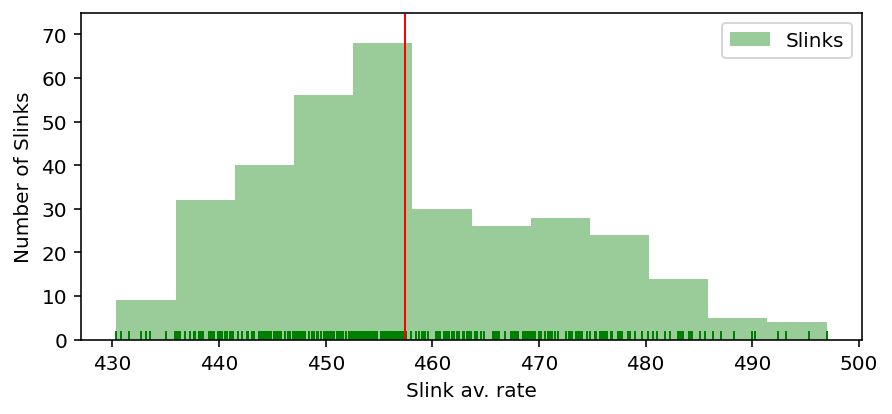

In [12]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)